### RSA FACTORING

In [2]:
import random
from sympy import randprime, mod_inverse
import numpy as np
import pennylane as qml

In [62]:

def generate_rsa_keys(bit_length):
    # Generate two distinct primes p and q
    p = randprime(2**(bit_length//2 - 1), 2**(bit_length//2))
    q = randprime(2**(bit_length//2 - 1), 2**(bit_length//2))
    while p == q:
        q = randprime(2**(bit_length//2 - 1), 2**(bit_length//2))

    n = p * q

    # Compute the totient of n
    totient = np.lcm(p - 1, q - 1)
    
    # Choose an integer e such that e and totient(n) are coprime
    e = random.randrange(1, totient)
    g = np.gcd(e, totient)
    while g != 1:
        e = random.randrange(1, totient)
        g = np.gcd(e, totient)

    # Compute d, the modular multiplicative inverse of e modulo totient(n)
    d = mod_inverse(e, totient)

    # Return the public and private keys
    return (e, n), (d, n)

# Generate and print RSA keys
public_key, private_key = generate_rsa_keys(32)
print(f"Public key:  {public_key}")
print(f"Private key: {private_key}")

Public key:  (93607279, 2561716159)
Private key: (313216519, 2561716159)


In [36]:
#Now, creating a code to get the kwy with known p and q
def key(p,q):
    n = p * q

    totient = np.lcm(p - 1, q - 1) 
    #e = random.randrange(1, totient) #To choose a random e with higher values
    e = 3
    g = np.gcd(e, totient)
    while g != 1:
        e = random.randrange(1, totient)
        g = np.gcd(e, totient)

    # Compute d, the modular multiplicative inverse of e modulo totient(n)
    d = mod_inverse(e, totient)

    # Return the public and private keys
    return (e, n), (d, n)
public_key, private_key = key(17,29)
print(f"Public key:  {public_key}")
print(f"Private key: {private_key}")

Public key:  (3, 493)
Private key: (75, 493)


In [39]:
public_key, private_key = key(17,29)

def rsa_encrypt(m, public_key):
    e, n = public_key
    return pow(m, e, n)

def rsa_decrypt(c, private_key):
    d, n = private_key
    return pow(c, d, n)
c = rsa_encrypt(42, public_key)
print(f"ciphertext: {c}"+" mod "+str(public_key[1]))
m = rsa_decrypt(c, private_key)
print(f"message: {m}"+" mod "+str(public_key[1]))

ciphertext: 138 mod 493
message: 42 mod 493


In [101]:
def encode_string(s):
    ascii_values = [ord(c) for c in s]
    length = 8
    arrays = [ascii_values[i:i+length] for i in range(0, len(ascii_values), length)]

    arrays = [[0]*(length-len(array)) + array for array in arrays]

    memory = [int.from_bytes(bytes(array), byteorder='big') for array in arrays]

    return memory
def back_to_string(memory):
    arrays = [list(int.to_bytes(memory_int, length=8, byteorder='big')) for memory_int in memory]

    ascii_values = [value for array in arrays for value in array]

    s = ''.join(chr(value) for value in ascii_values if value != 0)

    return s
    

In [99]:
message = "Bocadillo de txoriso mesi mesi"
print(f"message: {message}")
memory = encode_string(message)
public_key,private_key = generate_rsa_keys(64)
c = [rsa_encrypt(m, public_key) for m in memory]
print(f"ciphertext: {c}"+ " mod "+str(public_key[1]))
d = [rsa_decrypt(c, private_key) for c in c]
print(f"decrypted: {d}"+str(public_key[1]))
s = back_to_string(d)
print(f"message: {s}")

message: Bocadillo de txoriso mesi mesi
ciphertext: [9320167817222607433, 1590112442784330384, 1828388760813898685, 4934609375393949312] mod 9641571661781413469
decrypted: [4787154198865734764, 8007510522963720303, 8244247514001007987, 115587995235177]9641571661781413469
message: Bocadillo de txoriso mesi mesi


In [96]:
message = "Bocadillo de txoriso mesi mesi"
print(f"message: {message}")
memory = encode_string(message)
public_key,private_key = generate_rsa_keys(32)
c = [rsa_encrypt(m, public_key) for m in memory]
print(f"ciphertext: {c}"+ " mod "+str(public_key[1]))
d = [rsa_decrypt(c, private_key) for c in c]
print(f"decrypted: {d}"+str(public_key[1]))
s = back_to_string(d)
print(f"message: {s}")

message: Bocadillo de txoriso mesi mesi
ciphertext: [2084230251, 3374156727, 82781025, 3503890611] mod 3760781117
decrypted: [3503568325, 2427715829, 377674500, 387604182]3760781117
message: ÐÔ5Å´õÛ^Ö


This way we created a proper RSA algorithm. Now, realize how important the value of modulus is. For instance, if the keys we created are too small, the results will not be good. With 64 bits we can create a good enough algorithm, but with 32 the message returned is not the same!

### Running time of factoring numbers

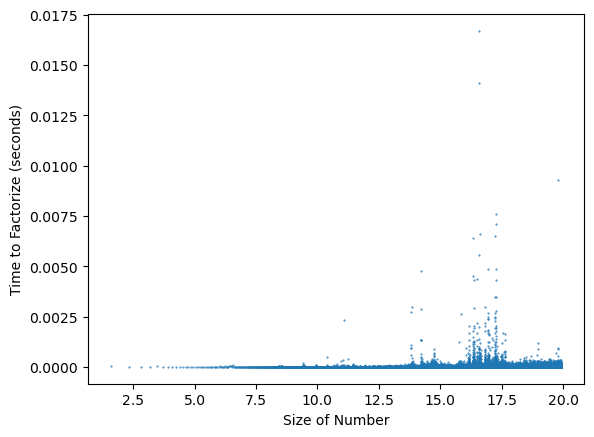

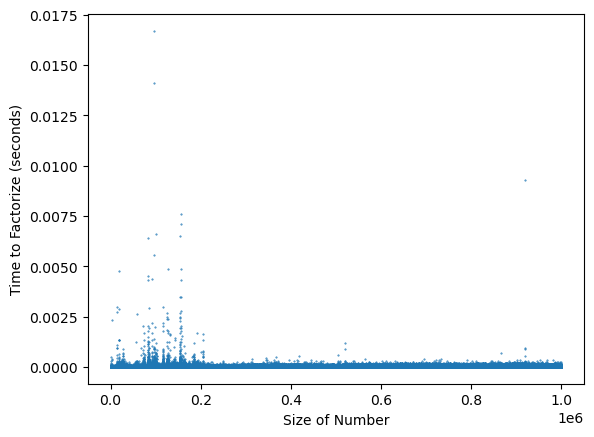

In [8]:
import matplotlib.pyplot as plt
import timeit
from sympy import factorint

# Sizes of numbers to factorize
sizes = range(3, 1000000, 2)

# Measure the time taken to factorize each number
times = []
for size in sizes:
    # Use timeit to measure the time taken to factorize the number
    timer = timeit.Timer(lambda: factorint(size))
    time_taken = timer.timeit(number=1)
    times.append(time_taken)

# Plot the results
# plt.plot(np.log2(sizes), times)
# plt.plot(sizes, times)
plt.scatter(np.log2(sizes), times, s=0.2)
plt.xlabel('Size of Number')
plt.ylabel('Time to Factorize (seconds)')
plt.show()
plt.scatter(sizes, times, s=0.2)
plt.xlabel('Size of Number')
plt.ylabel('Time to Factorize (seconds)')
plt.show()

As we can see there are some numbers that take some more time. This is due to factorizing the prime numbers takes more time.

### 4) QFT

In [14]:

dev = qml.device("default.qubit", wires=6)

@qml.qnode(dev)
def decompose_six_qubit_QFT(basis_id):
    """A circuit that computes the QFT on six qubits using elementary gates.
    
    Args:
        basis_id (int): An integer value identifying the basis state to construct.
    
    Returns:
        array[complex]: The state of the qubits after the QFT operation.
    """
    # Prepare the basis state |basis_id>
    bits = [int(x) for x in np.binary_repr(basis_id, width=dev.num_wires)]
    qml.BasisStatePreparation(bits, wires=range(6))

    for i in range(6):
        qml.Hadamard(wires=i)
        for j in range(i+1, 6):
            qml.ControlledPhaseShift(np.pi / 2**(j-i), wires=[i, j])
    
    # Reverse the order of the qubits
    for i in range(3):
        qml.SWAP(wires=[i, 5-i])

    return qml.state()

In [43]:
wires = 6

dev = qml.device('default.qubit',wires=wires)

@qml.qnode(dev)
def circuit_qft(basis_state):
    qml.BasisState(basis_state, wires=range(wires))
    qml.QFT(wires=range(wires))
    return qml.state()

circuit_qft(np.array([1.0, 0.0, 0.0,0.0,0.0,0.0], requires_grad=False))

tensor([ 0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
        -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,
         0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
        -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,
         0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
        -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,
         0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
        -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,
         0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
        -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,
         0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
        -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,
         0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j], requires_grad=True)

In [70]:
n_wires = 12

dev = qml.device("default.qubit", wires=n_wires)

@qml.qnode(dev)
def circuit():
    for wire in range(6):
        qml.Hadamard(wires=wire)

    
    for control in range(6):
        for target in range(6, 12):
            qml.CNOT(wires=[control, target])

    qml.adjoint(qml.QFT)(wires=range(6))

    return qml.probs(wires=range(6))

print(circuit())

[5.00000000e-01 3.22318909e-08 4.16411755e-32 1.19491636e-04
 7.65225097e-32 1.93543373e-03 2.42178028e-31 1.60864504e-03
 9.36575944e-32 3.84699934e-03 1.80285554e-30 3.03265451e-02
 1.41170705e-31 2.14028962e-02 1.06616072e-30 6.22395544e-04
 1.85587902e-31 7.57665146e-04 2.93889414e-30 3.89111354e-02
 2.70460541e-31 8.44156337e-02 2.55784248e-29 1.71974682e-02
 7.29364497e-31 1.25650917e-02 1.88756275e-29 3.08466540e-02
 2.09982924e-31 5.43055793e-03 4.22586844e-31 1.33551248e-05
 2.86008617e-31 1.33551248e-05 9.22869556e-31 5.43055793e-03
 7.59777824e-31 3.08466540e-02 3.75959010e-29 1.25650917e-02
 6.49298605e-31 1.71974682e-02 9.11066395e-29 8.44156337e-02
 2.63076540e-30 3.89111354e-02 1.61448729e-29 7.57665146e-04
 2.89130514e-30 6.22395544e-04 2.44956854e-29 2.14028962e-02
 3.69075041e-30 3.03265451e-02 4.64307207e-29 3.84699934e-03
 4.82753997e-30 1.60864504e-03 2.60520655e-29 1.93543373e-03
 1.92294256e-29 1.19491636e-04 1.10190926e-28 3.22318909e-08]


In [3]:
def U_power_2k(unitary, k):
    """ Computes U at a power of 2k (U^2^k)
    
    Args: 
        unitary (array[complex]): A unitary matrix
    
    Returns: 
        array[complex]: the unitary raised to the power of 2^k
    """
    return np.linalg.matrix_power(unitary,np.power(2,k)) 
    pass
            

# Try out a higher power of U
U = qml.T.compute_matrix()
print(U)

U_power_2k(U, 2)

[[1.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j]]


array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])

In [4]:
estimation_wires = [0, 1, 2]
target_wires = [3]

def apply_controlled_powers_of_U(unitary):
    """A quantum function that applies the sequence of powers of U^2^k to
    the estimation wires.
    
    Args: 
        unitary (array [complex]): A unitary matrix
    """

    for i in range(len(estimation_wires)):
	    qml.ControlledQubitUnitary(U_power_2k(unitary,3 - (i+1)), control_wires=estimation_wires[i],wires=target_wires)
    pass

In [5]:
dev = qml.device("default.qubit", wires=4)

estimation_wires = [0, 1, 2]
target_wires = [3]

def prepare_eigenvector():
    qml.PauliX(wires=target_wires)

@qml.qnode(dev)
def qpe(unitary):
    """ Estimate the phase for a given unitary.
    
    Args:
        unitary (array[complex]): A unitary matrix.
        
    Returns:
        array[float]: Measurement outcome probabilities on the estimation wires.
    """
    prepare_eigenvector()
    for wire in estimation_wires:
        qml.Hadamard(wires=wire)
    apply_controlled_powers_of_U(unitary)
    qml.adjoint(qml.QFT)(wires=estimation_wires)

    return qml.probs(wires=estimation_wires)
    

U = qml.T.compute_matrix()
print(qpe(U))

[1.51544285e-32 1.00000000e+00 1.86828208e-31 9.26372303e-32
 9.07320326e-32 9.32150093e-32 1.85684709e-31 3.94430453e-31]
